<a href="https://colab.research.google.com/github/bokrieya/disease_detection_plants/blob/main/GreenGoods_detector_maladies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.xception import Xception

import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

we are currently using tensorflow version 2.15.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import cv2

# Function to resize and replace an image
def resize_and_replace_image(image_path, target_size):
    # Load the original image
    image = cv2.imread(image_path)
    # Resize the image
    resized_image = cv2.resize(image, target_size)
    # Replace the original image with the resized one
    cv2.imwrite(image_path, resized_image)

# Folder containing the data files (images)
data_folder = "/content/drive/MyDrive/rice_leaf_diseases/Bacterial leaf blight"

# Target size for resizing the images
target_size = (244, 244)  # Specify the new width and height

# Loop through all files in the data folder
for filename in os.listdir(data_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Get the full path of the image file
        image_path = os.path.join(data_folder, filename)
        # Resize and replace the image
        resize_and_replace_image(image_path, target_size)


In [7]:
# Folder containing the data files (images)
data_folder = "/content/drive/MyDrive/rice_leaf_diseases/Brown spot"

# Target size for resizing the images
target_size = (244, 244)  # Specify the new width and height

# Loop through all files in the data folder
for filename in os.listdir(data_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Get the full path of the image file
        image_path = os.path.join(data_folder, filename)
        # Resize and replace the image
        resize_and_replace_image(image_path, target_size)


In [8]:
# Folder containing the data files (images)
data_folder = "/content/drive/MyDrive/rice_leaf_diseases/Leaf smut"

# Target size for resizing the images
target_size = (244, 244)  # Specify the new width and height

# Loop through all files in the data folder
for filename in os.listdir(data_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Get the full path of the image file
        image_path = os.path.join(data_folder, filename)
        # Resize and replace the image
        resize_and_replace_image(image_path, target_size)

In [9]:
input_shape_2D=(244, 244)
input_shape_3D= (244, 244, 3)
seed=1
batch_size=32
epochs=30
stopper=EarlyStopping(patience=5)

In [10]:
# Image data generator
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    validation_split=0.2  # Split data into training and validation sets
)

In [11]:
# Générateur de données pour l'entraînement avec augmentation des données
data_gen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,  # Rotate images by up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20%
    height_shift_range=0.2,  # Shift images vertically by up to 20%
    shear_range=0.2,  # Shear transformations with maximum shear angle of 20 degrees
    zoom_range=0.2,  # Zoom images by up to 20%
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest pixel value
)

data_ds = data_gen.flow_from_directory(
    directory='/content/drive/MyDrive/rice_leaf_diseases',
    target_size=input_shape_2D,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=20,
    shuffle=True,
    seed=seed,
    subset='training'
)

Found 120 images belonging to 3 classes.


In [12]:
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Loading validation data from directory without augmentation
validation_data_ds = validation_data_gen.flow_from_directory(
    directory='/content/drive/MyDrive/rice_leaf_diseases',
    target_size=input_shape_2D,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=seed,
    subset='validation'
)


Found 0 images belonging to 3 classes.


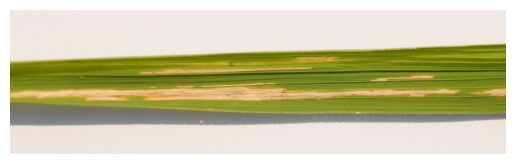

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the image file
img_path = '/content/drive/MyDrive/rice_leaf_diseases/Bacterial leaf blight/DSC_0372.JPG'

# Load and display the image
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

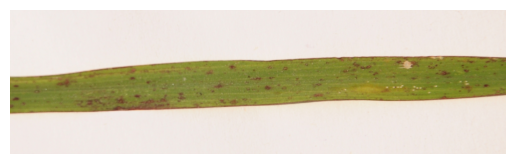

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the image file
img_path = '/content/drive/MyDrive/rice_leaf_diseases/Leaf smut/DSC_0313.JPG'

# Load and display the image
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()


In [15]:
from tensorflow.keras import models, layers

def create_complex_cnn(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with softmax for classification

    return model

In [16]:
input_shape = (244, 244, 3)
num_classes = 3

model = create_complex_cnn(input_shape, num_classes)

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 121, 121, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 59, 59, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

In [19]:
# Specify number of epochs
epochs = 20

# Train the model
history = model.fit(
    data_ds,
    epochs=epochs,
    validation_data=validation_data_ds
)

Epoch 1/20
6/6 [==============================] - 31s 4s/step - loss: 1.1837 - accuracy: 0.4000
Epoch 2/20
6/6 [==============================] - 22s 3s/step - loss: 1.1013 - accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 20s 3s/step - loss: 1.0939 - accuracy: 0.3167
Epoch 4/20
6/6 [==============================] - 20s 3s/step - loss: 1.0884 - accuracy: 0.3083
Epoch 5/20
6/6 [==============================] - 21s 3s/step - loss: 1.0352 - accuracy: 0.3750
Epoch 6/20
6/6 [==============================] - 20s 3s/step - loss: 1.0119 - accuracy: 0.4583
Epoch 7/20
6/6 [==============================] - 21s 3s/step - loss: 0.9700 - accuracy: 0.5667
Epoch 8/20
6/6 [==============================] - 20s 3s/step - loss: 0.8807 - accuracy: 0.6167
Epoch 9/20
6/6 [==============================] - 21s 3s/step - loss: 0.8513 - accuracy: 0.6167
Epoch 10/20
6/6 [==============================] - 24s 4s/step - loss: 0.8740 - accuracy: 0.6083
Epoch 11/20
6/6 [======================

In [20]:
from tensorflow.keras.preprocessing import image

# Load the image
img_path = '/content/drive/MyDrive/DSC_0333.JPG'
img = image.load_img(img_path, target_size=(244, 244))

# Convert the image to a NumPy array
img_array = image.img_to_array(img)
class_names = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]
# Preprocess the image (normalize pixel values)
img_array = img_array / 255.0

# Expand the dimensions of the image array to match the input shape expected by the model
img_array = np.expand_dims(img_array, axis=0)

# Use the trained model to make predictions
predictions = model.predict(img_array)

# Interpret the predictions
predicted_class = np.argmax(predictions)

# Print the predicted class
class_name = class_names[predicted_class]
print("Predicted class:", class_name)

1/1 [==============================] - 0s 177ms/step
Predicted class: Bacterial leaf blight


In [ ]:
from tensorflow.keras.preprocessing import image

# Load the image
img_path = '/content/drive/MyDrive/DSC_0101.jpg'
img = image.load_img(img_path, target_size=(244, 244))

# Convert the image to a NumPy array
img_array = image.img_to_array(img)
class_names = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]
# Preprocess the image (normalize pixel values)
img_array = img_array / 255.0

# Expand the dimensions of the image array to match the input shape expected by the model
img_array = np.expand_dims(img_array, axis=0)

# Use the trained model to make predictions
predictions = model.predict(img_array)

# Interpret the predictions
predicted_class = np.argmax(predictions)

# Print the predicted class
class_name = class_names[predicted_class]
print("Predicted class:", class_name)

1/1 [==============================] - 0s 63ms/step
Predicted class: Bacterial leaf blight
